## Import Required Libraries

In [5]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.metrics import silhouette_score



## Load the Dataset

In [6]:
# Load datasets
file_path = 'dataset/movies.csv'
file_path2 = 'dataset/ratings.csv'
movies = pd.read_csv(file_path)  # Movie information
ratings = pd.read_csv(file_path2)  # User ratings


## Explanatory Data Analysis

In [7]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [9]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [10]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


C:\Users\Natan\AppData\Local\Temp\ipykernel_14960\2038653828.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating", data=ratings, palette="viridis")


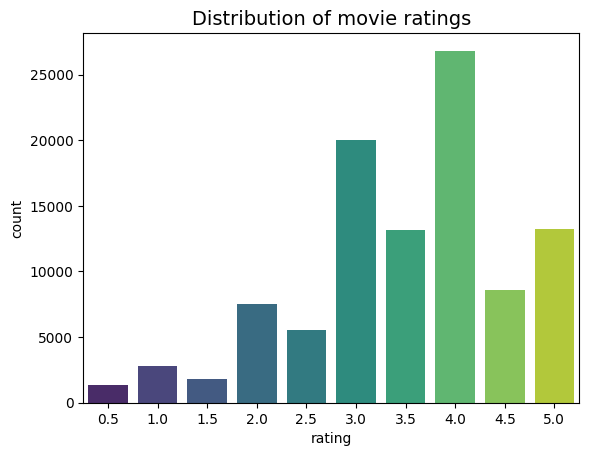

In [11]:
sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [12]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


In [13]:
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")

mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 3.5.
Mean rating per user: 3.66.


In [14]:
movie_ratings = ratings.merge(movies, on='movieId')
movie_ratings['title'].value_counts()[0:10]

title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: count, dtype: int64

In [15]:
print("LOWEST RATED MOVIE")
mean_ratings = ratings.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
movies[movies['movieId']==lowest_rated]

LOWEST RATED MOVIE


,movieId,title,genres
2689,3604,Gypsy (1962),Musical


In [16]:
print("HIGHEST RATED MOVIE")
highest_rated = mean_ratings['rating'].idxmax()
movies[movies['movieId'] == highest_rated]

HIGHEST RATED MOVIE


,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


#### Bayesian Average

In [17]:
movie_stats = ratings.groupby('movieId')['rating'].agg(['count', 'mean'])
# movie_stats.head()

C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

# print(f"Average number of ratings for a given movie: {C:.2f}")
# print(f"Average rating for a given movie: {m:.2f}")

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return round(bayesian_avg, 3)

bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats.sort_values('bayesian_avg', ascending=False).head()

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227,Fight Club (1999)
224,260,251,4.231076,4.193,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.191,"Usual Suspects, The (1995)"


#### Highest and lowest rated movies using Bayesian Average

In [18]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title
1172,1556,19,1.605263,2.190,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,2.224,Battlefield Earth (2000)
1372,1882,33,1.954545,2.267,Godzilla (1998)
1144,1499,27,1.925926,2.297,Anaconda (1997)
1988,2643,16,1.687500,2.307,Superman IV: The Quest for Peace (1987)


In [19]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


#### About Genres

In [20]:
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 20 genres.


Counter({'Drama': 4361,
         'Comedy': 3756,
         'Thriller': 1894,
         'Action': 1828,
         'Romance': 1596,
         'Adventure': 1263,
         'Crime': 1199,
         'Sci-Fi': 980,
         'Horror': 978,
         'Fantasy': 779,
         'Children': 664,
         'Animation': 611,
         'Mystery': 573,
         'Documentary': 440,
         'War': 382,
         'Musical': 334,
         'Western': 167,
         'IMAX': 158,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [21]:
print("The 5 most common genres: \n", genre_frequency.most_common(5))

The 5 most common genres: 
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


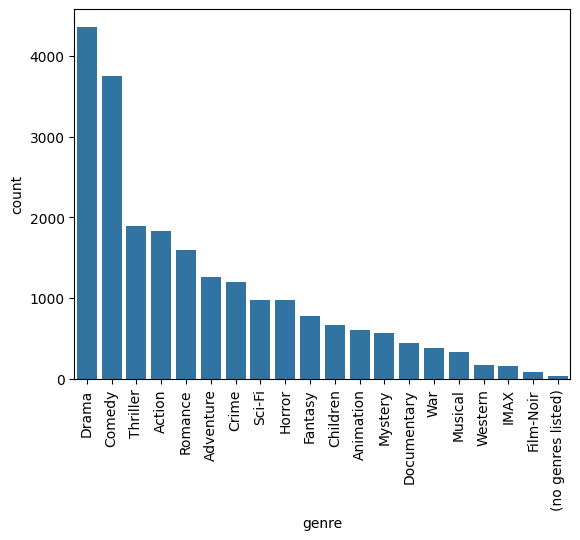

In [22]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']

sns.barplot(x='genre', y='count', data=genre_frequency_df.sort_values(by='count', ascending=False))
plt.xticks(rotation=90)
plt.show()

## Preprocess the Data

In [23]:
# Split genres into separate columns
genres = movies['genres'].str.get_dummies('|')

# Calculate average rating for each movie
movie_ratings = ratings.groupby('movieId')['rating'].mean().reset_index()
movie_ratings.rename(columns={'rating': 'avg_rating'}, inplace=True)

# Merge genres and ratings
movie_data = movies.merge(movie_ratings, on='movieId')
movie_data = pd.concat([movie_data, genres], axis=1)

# Keep only relevant columns
features = movie_data.drop(['movieId', 'title', 'genres'], axis=1)

In [24]:
print(features.isnull().sum())

avg_rating                                                               18
['(no genres listed)']                                                    0
['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy']     0
['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'IMAX']        0
['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Romance']     0
                                                                         ..
['Sci-Fi', 'Thriller']                                                    0
['Sci-Fi']                                                                0
['Thriller']                                                              0
['War']                                                                   0
['Western']                                                               0
Length: 952, dtype: int64


In [25]:
features.fillna(features.mean(), inplace=True)

#### Normalize the Data

In [26]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

## Apply Clustering
#### Use K-Means Clustering

In [27]:
# Apply K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
movie_data['cluster'] = kmeans.fit_predict(scaled_features)

# Add cluster labels to the dataset
print(movie_data[['title', 'cluster']].head())

                                title  cluster
0                    Toy Story (1995)        0
1                      Jumanji (1995)        0
2             Grumpier Old Men (1995)        0
3            Waiting to Exhale (1995)        0
4  Father of the Bride Part II (1995)        0


## Visualize the Clusters
#### Use PCA for Dimensionality Reduction

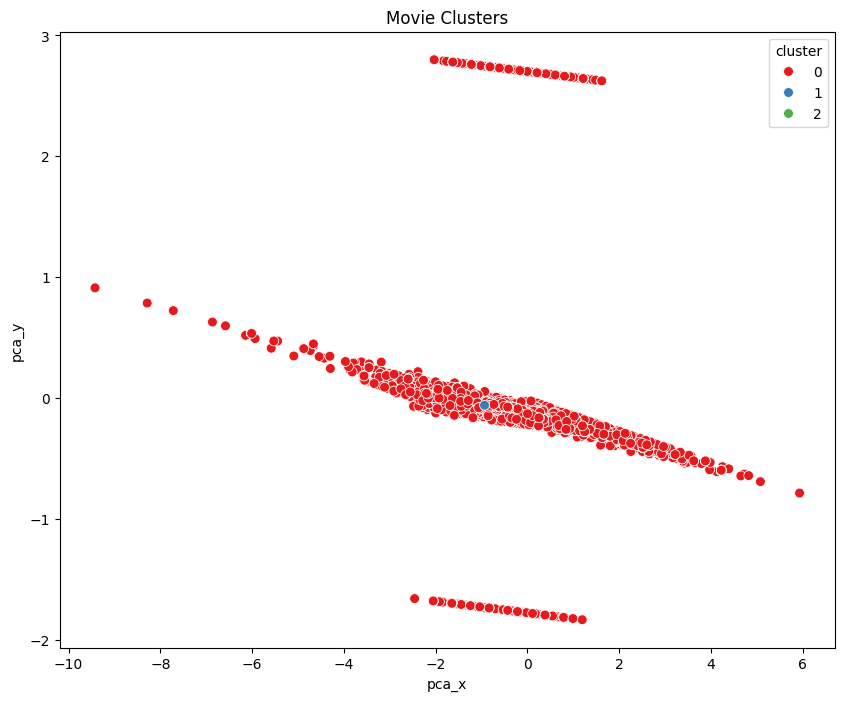

In [28]:
# Reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)
movie_data['pca_x'] = reduced_features[:, 0]
movie_data['pca_y'] = reduced_features[:, 1]

# Plot the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='pca_x', y='pca_y', hue='cluster', data=movie_data,
    palette='Set1', s=50
)
plt.title('Movie Clusters')
plt.show()


## Recommend Movies
#### Find Movies in the Same Cluster

In [29]:
def recommend_movies(movie_title, data, n_recommendations=5):
    # Find the cluster of the given movie
    cluster = data[data['title'] == movie_title]['cluster'].values[0]
    
    # Recommend movies from the same cluster
    recommendations = data[data['cluster'] == cluster]['title'].sample(n_recommendations)
    return recommendations.tolist()

# Example recommendation
print(recommend_movies('Toy Story (1995)', movie_data))


["Legend of the Guardians: The Owls of Ga'Hoole (2010)", 'Tango (1998)', 'Nuremberg (2000)', 'Armageddon (1998)', 'Wow! A Talking Fish! (1983)']


## Evaluate the Model
#### Use metrics like silhouette score to evaluate the quality of clusters:

In [30]:
score = silhouette_score(scaled_features, kmeans.labels_)
print(f"Silhouette Score: {score}")

Silhouette Score: 0.36107132187532076


## Apply clustering 2
#### Apply Hierarchical Clustering

In [31]:
# Apply Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=20, metric='euclidean', linkage='ward')
movie_data['cluster_hierarchical'] = hierarchical.fit_predict(scaled_features)

# Check the clusters
print(movie_data[['title', 'cluster_hierarchical']].head())


                                title  cluster_hierarchical
0                    Toy Story (1995)                     1
1                      Jumanji (1995)                     0
2             Grumpier Old Men (1995)                     5
3            Waiting to Exhale (1995)                     8
4  Father of the Bride Part II (1995)                     2


#### Visualize Dendrogram
* A dendrogram helps to visualize the hierarchical relationships between clusters.

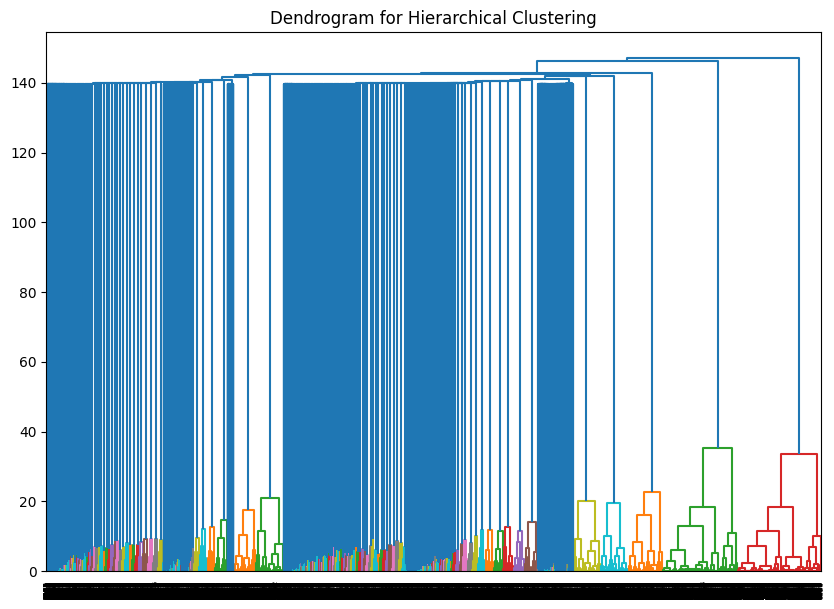

In [32]:
# Generate the linkage matrix
linked = linkage(scaled_features, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=False)
plt.title('Dendrogram for Hierarchical Clustering')
plt.show()

#### Visualize the clusters

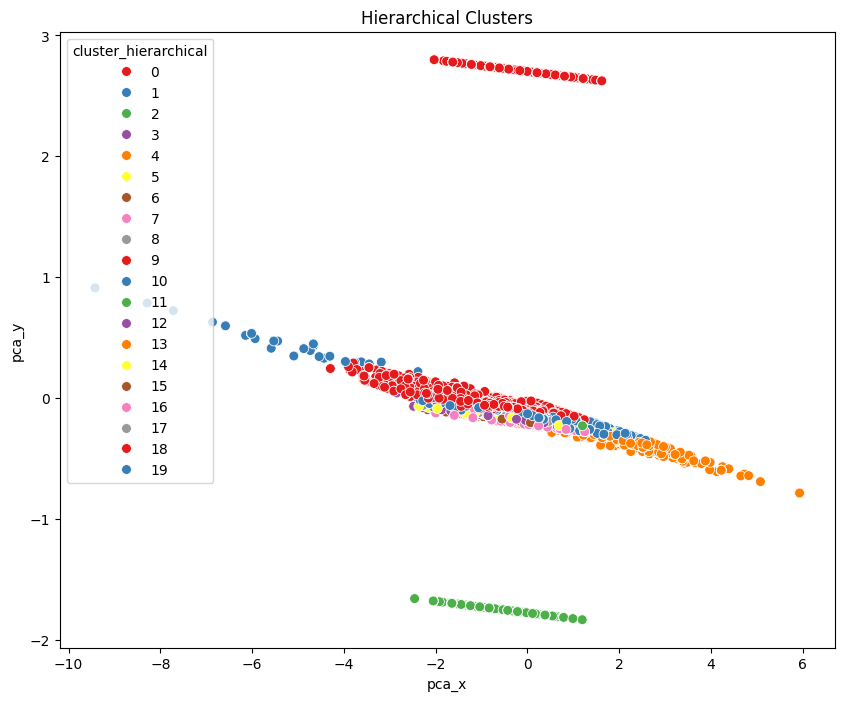

In [33]:
# Reduce dimensions for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)
movie_data['pca_x'] = reduced_features[:, 0]
movie_data['pca_y'] = reduced_features[:, 1]

# Plot the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='pca_x', y='pca_y', hue='cluster_hierarchical', data=movie_data,
    palette='Set1', s=50
)
plt.title('Hierarchical Clusters')
plt.show()

In [34]:
labels = hierarchical.fit_predict(scaled_features)
score = silhouette_score(scaled_features, labels)
print(f"Silhouette Score: {score}")


Silhouette Score: 0.2159686526756366



#### Apply Hierarchical Clustering using the "linkage='average'"

In [35]:
# Apply Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=20, metric='euclidean', linkage='average')
movie_data['cluster_hierarchical'] = hierarchical.fit_predict(scaled_features)

# Check the clusters
print(movie_data[['title', 'cluster_hierarchical']].head())

                                title  cluster_hierarchical
0                    Toy Story (1995)                     0
1                      Jumanji (1995)                     0
2             Grumpier Old Men (1995)                     0
3            Waiting to Exhale (1995)                     0
4  Father of the Bride Part II (1995)                     0


In [36]:
labels = hierarchical.fit_predict(scaled_features)
score = silhouette_score(scaled_features, labels)
print(f"Silhouette Score: {score}")

Silhouette Score: 0.693995637529333


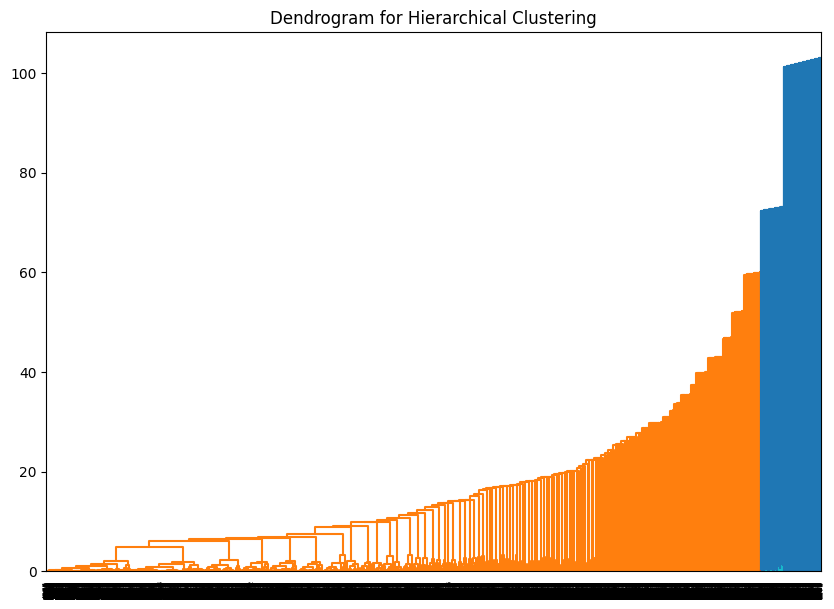

In [39]:
# Generate the linkage matrix
linked = linkage(scaled_features, method='average')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=False)
plt.title('Dendrogram for Hierarchical Clustering')
plt.show()

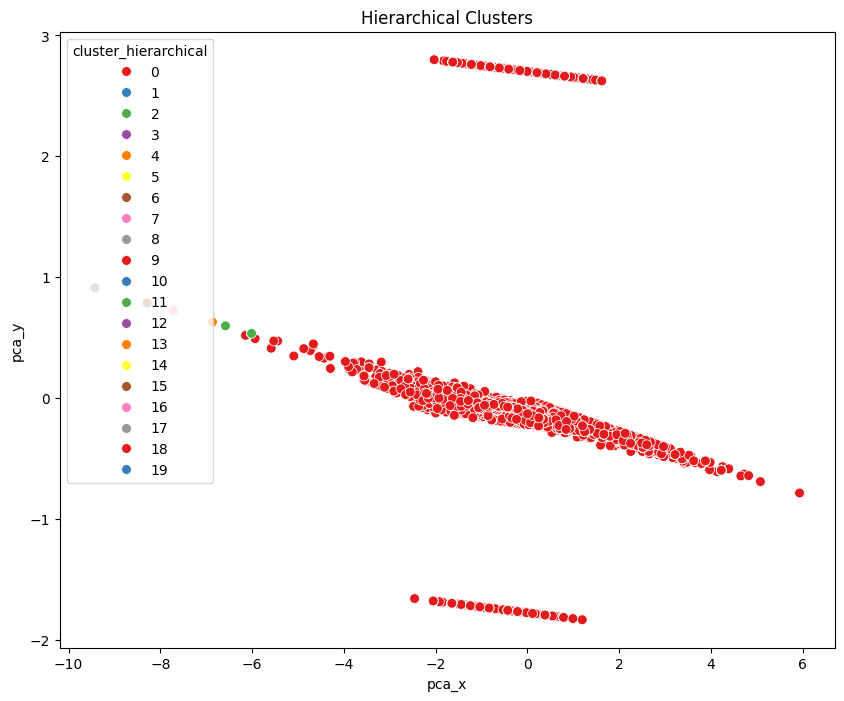

In [37]:
# Reduce dimensions for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)
movie_data['pca_x'] = reduced_features[:, 0]
movie_data['pca_y'] = reduced_features[:, 1]

# Plot the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='pca_x', y='pca_y', hue='cluster_hierarchical', data=movie_data,
    palette='Set1', s=50
)
plt.title('Hierarchical Clusters')
plt.show()